# Pumping Test Evaluation - Theis Recovery

*Notebook by Tanja Liesch partly based on content by Christian Hill: https://scipython.com/blog/linear-and-non-linear-fitting-of-the-theis-equation/*

## The Theis equation
The _drawdown_ or change in hydraulic head, $s$ (a measure of the water pressure above some geodetic datum) a distance $r$ from a well at time $t$ from which water is being pumped at a constant rate, $Q$, can be modelled using the _Theis_ equation,
$$
s(u) = \frac{Q}{4\pi T}W(u), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt}.
$$
Here $S$ is the aquifer storage coefficient (volume of water released per unit decrease in $H$ per unit area) and $T$ is the transmissivity (a measure of how much water is transported horizontally per unit time). The _Well Function_, $W(u)$ is simply the exponential integral, $E_1(u).$

In practice, it is often more convenient to use an approximation to the exponential integral: $W(u) \approx -\gamma - \ln u$ where $\gamma=0.577215664\cdots$ is the Euler-Mascheroni constant. This results in an expression for $s(u)$ known as the Cooper-Jacob equation:
$$
s(u) = -\frac{Q}{4\pi T}\left(\gamma + \ln u \right).
$$


## Principle of Superposition

If the drawdown cone in an aquifer under the effect of a pumping test is superimposed by another drawdown or injection, the resulting drawdown is calculated as the sum of the drawdowns induced by each pumping well separately. Each increment of the pumping-well discharge rate creates an additional term in the sum of drawdown values. For injection or recharge wells, the same applies, only with a the opposite sign (impression = negative drawdown).

$$
s_r = s_1 + s_2 + s_3 + ...
$$

The analytical solution for describing water-level recovery after a pumping test
is constructed based on the superposition principle, which, in
this case, determines the water-level changes in a well as the sum of drawdown
values corresponding to two periods: pumping from the well with a discharge rate Q with time $t$ (time after start of pumping) and (imaginary) injection in the same well, with the same injection rate $-Q$ starting at time $t'$ (time after pumping stop) - so the net discharge rate is zero.

$$
s_r = s + s' = \frac{Q}{4\pi T}W(u) + \frac{-Q}{4\pi T}W(u')
$$

where 

$$
u = \frac{r^2S}{4Tt} \quad \mathrm{and}\quad u' = \frac{r^2S}{4Tt'}
$$


Applying the Cooper-Jacob approximation leads to

$$
s_r = \frac{Q}{4\pi T}\left(-0.5772 - \ln u - \left(-0.5772 - \ln u' \right)\right)
$$
$$
= \frac{Q}{4\pi T}\ln \frac{u'}{u}
$$

or 

$$
s_r = \frac{2.30 Q}{4\pi T}\lg\frac{t}{t'}
$$


The following code uses `scipy.special.exp1` to calculate some sample values, returning $s_r$ for parameters $Q$, $S$, $T$, $t$ and $t'$ (for coding reasons u1 is used for u' and t1 for t').

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1

def calc_u(r, S, T, t):
    """Calculate and return the dimensionless time parameter, u."""

    return r**2 * S / 4 / T / t

def calc_u1(r, S, T, t1):
    """Calculate and return the dimensionless time parameter, u."""

    return r**2 * S / 4 / T / t1

In [2]:
def theis_drawdown(t, S, T, Q, r):
    """Calculate and return the drawdown s(u) for parameters S, T.

    This version uses the Theis equation, s(u) = Q * W(u) / (4.pi.T),
    where W(u) is the Well function for u = Sr^2 / (4Tt).
    S is the aquifer storage coefficient,
    T is the transmissivity (m2/s),
    r is the distance from the well (m), and
    Q is the pumping rate (m3/s).

    """

    u = calc_u(r, S, T, t)
    s_theis = Q/4/np.pi/T * exp1(u)
    return s_theis

def theis_impression(t1, S, T, Q, r):
    """Calculate and return the impression s(u) for parameters S, T.

    This version uses the Theis equation, s(u) = Q * W(u) / (4.pi.T),
    where W(u) is the Well function for u = Sr^2 / (4Tt).
    S is the aquifer storage coefficient,
    T is the transmissivity (m2/s),
    r is the distance from the well (m), and
    Q is the pumping rate (m3/s).

    """

    u1 = calc_u1(r, S, T, t1)
    s1_theis = - Q/4/np.pi/T * exp1(u1)
    return s1_theis

def theis_recovery(s_theis, s1_theis):
    """Calculate and return the recovery as the superposition
    of drawdown and impression.

    """
    s_r = s_theis +  s1_theis
    return s_r

Let's simulate a curve for $s(t)$ for a fixed distance from the well, $r=10\;\mathrm{m}$, and pumping rate $Q = 0.002\;\mathrm{m^3/s}$ for a well with parameters $S = 0.001$ and $T = 0.001\;\mathrm{m^2/s}$. Pumping was stopped after 1200 seconds.

We'll add a bit of synthetic normally-distributed noise to get some realistic data simulating measurement errors (since the noise is random, slightly different values will be produced each time you run the code).

In [3]:
Q = 0.002       # Pumping rate from well (m3/s)
r = 10          # Distance from well (m)

# Time grid, seconds
t = np.array([1320, 1360, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2400 ])
t1 = np.array([120, 160, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200])

# Calculate some synthetic data to fit
S, T = 0.001, 0.001
s = theis_drawdown(t, S, T, Q, r)
s1 = theis_impression(t1, S, T, Q, r)
s_r = theis_recovery(s, s1)

# Add some noise
noise_sd = 5.e-3
s_r += s_r * noise_sd * np.random.randn(s.shape[0])
print(s_r)

[0.35288631 0.3181616  0.29331294 0.2461839  0.2136719  0.18715657
 0.17109032 0.15588342 0.14475878 0.13349776 0.12403596 0.10960913]


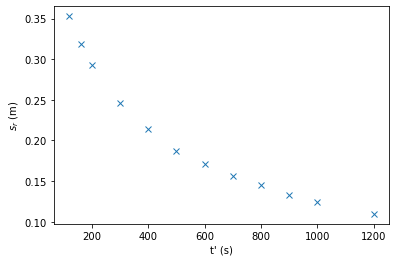

In [4]:
# Plot the data
plt.plot(t1, s_r, 'x')
plt.xlabel("t' (s)")
plt.ylabel("$s_r$ (m)")
plt.show()

## Fitting the data

### Linear least squares fit

The Theis and Jacob recovery equation produces a straight-line plot, since:

$$
s_r = \frac{2.30 Q}{4\pi T}\lg\frac{t}{t'}
$$

So a plot of $s_r$ against $\lg\frac{t}{t'}$ is a straight line with the gradient
$$
m = \frac{2.30 Q}{4\pi T}
$$
hence,
$$
T = \frac{2.30 Q}{4\pi m}
$$

The most straightforward approach is to use NumPy's [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) routine to fit a first-order polynomial (i.e. a straight line) through the data points $(s, \lg \frac{t}{t'})$:

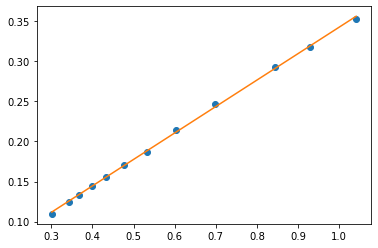

m = 0.3297284763132608, c = 0.012709526633074236
rms residual = 0.006396063913296907


In [5]:
# fit s, lg(t/t')
t2 = t/t1
lgt = np.log10(t2)
coeffs = np.polyfit(np.log10(t2), s_r, 1)

# plot the data and the fitted straight line
plt.plot(lgt, s_r, ls='', marker='o')
fit_line = np.poly1d(coeffs)(lgt)
plt.plot(lgt, fit_line)
plt.show()

# Output the fitted coefficients and report the rms residual
print('m = {}, c = {}'.format(*coeffs))
rms_residual = np.sqrt(np.sum((fit_line - s_r)**2))
print('rms residual =', rms_residual)

For aquifers without boundaries, c should be zero or close to it. The parameter $T$ which best fits the data is found to be as follows:

In [6]:
m = coeffs[0] # read m value from coeffs

Tfit = 2.3 * Q / 4 / np.pi / m

print('T = %.3f m2/s' %(Tfit))

T = 0.001 m2/s


The same analysis can be performed using [`numpy.linalg.lstsq`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) which returns the sum of the square residuals along with other information about the fit:

In [7]:
A = np.vstack((lgt, np.ones_like(t2))).T
x, sq_resid, rank, sing_vals = np.linalg.lstsq(A, s_r, rcond=None)
m, c = x
Tfit = 2.3 * Q / 4 / np.pi / m
print('T = %.3f m2/s' %(Tfit))
print('rms residual = %.3f' %(np.sqrt(sq_resid[0])))

T = 0.001 m2/s
rms residual = 0.006


#### Analysing a real world recovery test

If we want to analyse a real world test, we must replace the synthetic data values we created above with the real values, along with the correct pumping rate $Q$ and distance to pumping well $r$. Here is an example (values from excercise a):

In [8]:
Q = 0.0267       # Pumping rate from well (m3/s)
r = 27.4          # Distance from well (m)

t = np.array([14765,14823,14871,14920,15235,15332,15600,15810,16180,16400,17300,17900,18560,19220,20700,23300])
t1 = np.array([165,223,271,320,635,732,1000,1210,1580,1800,2700,3300,3960,4620,6100,8700])
s_r = np.array([1.03,0.95,0.90,0.85,0.69,0.65,0.59,0.55,0.47,0.44,0.35,0.30,0.26,0.23,0.17,0.09])



We use the Theis recovery curve fit from above again:

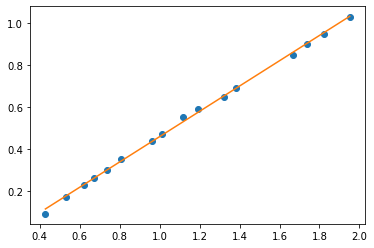

m = 0.603310488049656, c = -0.14442129121686528
rms residual = 0.039857889607413766
T = 0.008 m2/s


In [9]:
from scipy.optimize import curve_fit

# fit s, lg(t/t')
t2 = t/t1
lgt = np.log10(t2)
coeffs = np.polyfit(np.log10(t2), s_r, 1)

# plot the data and the fitted straight line
plt.plot(lgt, s_r, ls='', marker='o')
fit_line = np.poly1d(coeffs)(lgt)
plt.plot(lgt, fit_line)
plt.show()

# Output the fitted coefficients and report the rms residual
print('m = {}, c = {}'.format(*coeffs))
rms_residual = np.sqrt(np.sum((fit_line - s_r)**2))
print('rms residual =', rms_residual)

m = coeffs[0]
Tfit = 2.30 * Q / 4 / np.pi / m
print('T = %.3f m2/s' %(Tfit))



We now reformat the plot, so that the x-axis is formated in log-style and we can see the intersection of the fit line with the x-axis better:

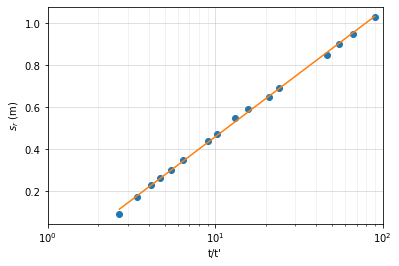

T = 0.008 m2/s


In [10]:
#Plot in nicer format (log x-axis)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(xlabel="t/t'", ylabel='$s_r$ (m)', xscale='log',xlim=(1e0,1e2))
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.plot(t2,s_r, 'o')
fit_line = np.poly1d(coeffs)(lgt)
ax.plot(t2, fit_line)
plt.show()

Tfit = 2.30 * Q / 4 / np.pi / m
print('T = %.3f m2/s' %(Tfit))

In comparison to the manual analysis (compare solution in pdf file), the gradient of the line fit is a bit higher (0.60 vs. 0.58), resulting in a slightly bigger value for $T$. The intersection point is about the same as in the manual solution at about 2.